In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials



In [2]:
SEED = 0

In [3]:
col_name = ['pregnant','glucose','blood_pressure','triceps','insulin','mass_index','pedigree','age','diabetes']
dataset = pd.read_csv('data/pima-indians-diabetes.csv', header=None)
dataset.columns = col_name
dataset



,pregnant,glucose,blood_pressure,triceps,insulin,mass_index,pedigree,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
dataset.isnull().sum()

pregnant          0
glucose           0
blood_pressure    0
triceps           0
insulin           0
mass_index        0
pedigree          0
age               0
diabetes          0
dtype: int64

In [5]:
dataset['diabetes'].value_counts()

0    500
1    268
Name: diabetes, dtype: int64

In [6]:
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=SEED)

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

In [9]:
earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=10) 

In [10]:
def model(params):
    
    print("--------------------")
    print("HyperParam Test")
    print(params)
    print('\n')
    
    model = Sequential([
        Dense(units=int(params['units1']), input_dim = X_train.shape[1], kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation(params['activation']),
        
        Dense(units=int(params['units2']), kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation(params['activation']),
        
        Dense(units=1),
        Activation('sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=params['learning_rate']), 
                  metrics=['accuracy'])
    
    model.fit(X_train,
              y_train, 
              validation_data = (X_val, y_val),
              epochs=int(params['epochs']), 
              batch_size=int(params['batch_size']),
              verbose=0,
              callbacks=[earlystop])
    
    val_loss, val_acc = model.evaluate(X_test,y_test)
    print('Accuracy: {:.5f}'.format(val_acc))
    print('Loss: {:.5f}'.format(val_loss))
    
    return {'loss': val_loss, 'status':STATUS_OK, 'Trained_Model':model}
    
    

In [11]:
space = {
    'units1':hp.choice('units1',[8, 16, 32, 64]),
    'units2':hp.choice('units2',[8, 16, 32, 64]),
    'batch_size' : hp.quniform('batch_size',2, 10, 2),
    'epochs' : hp.quniform('epochs', 50, 1000, 50),
    'activation':'relu',
    'learning_rate':hp.uniform('learning_rate', 0.001, 0.01)
}

In [12]:
# max_eval이 클경우 메모리 부족으로 pc 에러 발생
trials = Trials()
best = fmin(model, space, algo=tpe.suggest, trials=trials, max_evals=20)

--------------------                                                                                                   
HyperParam Test                                                                                                        
{'activation': 'relu', 'batch_size': 8.0, 'epochs': 250.0, 'learning_rate': 0.005049343789754606, 'units1': 32, 'units2': 64}
 32/154 [=====>........................]                                                                               
 - ETA: 0s                                                                                                             
                                                                                                                      
154/154 [==============================]                                                                               
 - 0s 84us/step                                                                                                        

Accuracy: 0.79870                 

 - 0s 84us/step                                                                                                        

Accuracy: 0.78571                                                                                                      
Loss: 0.45704                                                                                                          
--------------------                                                                                                   
HyperParam Test                                                                                                        
{'activation': 'relu', 'batch_size': 10.0, 'epochs': 350.0, 'learning_rate': 0.005248441435130572, 'units1': 8, 'units2': 32}
 32/154 [=====>........................]                                                                               
 - ETA: 0s                                                                                                             
                                 

 - ETA: 0s                                                                                                             
                                                                                                                      
154/154 [==============================]                                                                               
 - 0s 71us/step                                                                                                        

Accuracy: 0.82468                                                                                                      
Loss: 0.44591                                                                                                          
--------------------                                                                                                   
HyperParam Test                                                                                                        
{'activation': 'relu', 'batch_size': 4.0

In [13]:
print (best)
print (trials.best_trial)


{'batch_size': 8.0, 'epochs': 150.0, 'learning_rate': 0.0035263912255167383, 'units1': 0, 'units2': 2}
{'state': 2, 'tid': 9, 'spec': None, 'result': {'loss': 0.4298501808147926, 'status': 'ok', 'Trained_Model': <keras.engine.sequential.Sequential object at 0x000001A609999C88>}, 'misc': {'tid': 9, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'batch_size': [9], 'epochs': [9], 'learning_rate': [9], 'units1': [9], 'units2': [9]}, 'vals': {'batch_size': [8.0], 'epochs': [150.0], 'learning_rate': [0.0035263912255167383], 'units1': [0], 'units2': [2]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2020, 1, 9, 7, 46, 23, 767000), 'refresh_time': datetime.datetime(2020, 1, 9, 7, 46, 31, 497000)}


In [14]:
def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['Trained_Model']

In [15]:
model = getBestModelfromTrials(trials)

In [16]:
# model = Sequential([
#     Dense(units=12, input_dim = len(X[0])),
#     BatchNormalization(),
#     Activation('relu'),
#     Dense(units=8),
#     BatchNormalization(),
#     Activation('relu'),
#     Dense(units=4),
#     BatchNormalization(),
#     Activation('relu'),
#     Dense(units=1),
#     Activation('sigmoid')
# ])

In [17]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 8)                 72        
_________________________________________________________________
batch_normalization_19 (Batc (None, 8)                 32        
_________________________________________________________________
activation_28 (Activation)   (None, 8)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                288       
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
activation_29 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)               

In [18]:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# model.fit(X_train,y_train, validation_split = 0.3, epochs=500, batch_size=5, callbacks=[earlystop])

In [20]:
val_loss, val_acc = model.evaluate(X_test,y_test)
print('Accuracy: {:.5f}'.format(val_acc))
print('Loss: {:.5f}'.format(val_loss))

154/154 [==============================] - 0s 58us/step
Accuracy: 0.83766
Loss: 0.42985


In [21]:
rslt_y = y_test.reset_index(drop=True)
rslt_y

0      1
1      0
2      0
3      1
4      0
      ..
149    1
150    0
151    1
152    0
153    0
Name: diabetes, Length: 154, dtype: int64

In [22]:
df_rslt = pd.DataFrame(X_test)
df_rslt['rslt_y'] = rslt_y


In [23]:
df_rslt['pred_val'] = model.predict(df_rslt.iloc[:,:-1])
df_rslt

,0,1,2,3,4,5,6,7,rslt_y,pred_val
0,-0.828773,2.497835,0.335945,1.398353,-0.674563,1.313249,2.817495,-0.952248,1,0.930941
1,-0.536020,-0.440045,0.238573,0.591256,0.166307,0.177534,-0.155419,-0.869670,0,0.121062
2,0.049488,-1.429982,-0.345663,-1.271276,-0.674563,0.226382,-0.194457,-0.704515,0,0.138827
3,0.342242,1.444030,0.141200,-0.091672,0.796960,-0.775001,0.394120,1.442499,1,0.564847
4,-1.121527,-0.312311,-0.199604,-1.271276,-0.674563,-0.921545,0.613334,-0.209051,0,0.090570
...,...,...,...,...,...,...,...,...,...,...
149,-0.536020,-0.503911,0.530690,1.522522,0.931499,0.189746,0.766485,-0.374206,1,0.157104
150,0.049488,-1.142581,-0.540408,0.094581,-0.262537,-0.530762,-0.449708,-0.456783,0,0.076868
151,0.049488,0.677627,0.822808,-1.271276,-0.674563,1.447581,0.568290,-0.952248,1,0.621456
152,-0.243266,-0.152643,0.238573,-0.340010,0.208351,-0.713941,-1.047294,-0.787093,0,0.063501


In [24]:
df_rslt['pred_class'] = model.predict_classes(df_rslt.iloc[:,:-2])
df_rslt

,0,1,2,3,4,5,6,7,rslt_y,pred_val,pred_class
0,-0.828773,2.497835,0.335945,1.398353,-0.674563,1.313249,2.817495,-0.952248,1,0.930941,1
1,-0.536020,-0.440045,0.238573,0.591256,0.166307,0.177534,-0.155419,-0.869670,0,0.121062,0
2,0.049488,-1.429982,-0.345663,-1.271276,-0.674563,0.226382,-0.194457,-0.704515,0,0.138827,0
3,0.342242,1.444030,0.141200,-0.091672,0.796960,-0.775001,0.394120,1.442499,1,0.564847,1
4,-1.121527,-0.312311,-0.199604,-1.271276,-0.674563,-0.921545,0.613334,-0.209051,0,0.090570,0
...,...,...,...,...,...,...,...,...,...,...,...
149,-0.536020,-0.503911,0.530690,1.522522,0.931499,0.189746,0.766485,-0.374206,1,0.157104,0
150,0.049488,-1.142581,-0.540408,0.094581,-0.262537,-0.530762,-0.449708,-0.456783,0,0.076868,0
151,0.049488,0.677627,0.822808,-1.271276,-0.674563,1.447581,0.568290,-0.952248,1,0.621456,1
152,-0.243266,-0.152643,0.238573,-0.340010,0.208351,-0.713941,-1.047294,-0.787093,0,0.063501,0


In [41]:
rslt_tbl = df_rslt[['rslt_y', 'pred_val','pred_class']]
rslt_tbl

,rslt_y,pred_val,pred_class
0,1,0.930941,1
1,0,0.121062,0
2,0,0.138827,0
3,1,0.564847,1
4,0,0.090570,0
...,...,...,...
149,1,0.157104,0
150,0,0.076868,0
151,1,0.621456,1
152,0,0.063501,0


In [50]:
# precision_recall_fscore_support(rslt_tbl['rslt_y'], rslt_tbl['pred_class'])

(array([0.88679245, 0.72916667]),
 array([0.87850467, 0.74468085]),
 array([0.88262911, 0.73684211]),
 array([107,  47], dtype=int64))

In [48]:
print(classification_report(rslt_tbl['rslt_y'], rslt_tbl['pred_class']))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       107
           1       0.73      0.74      0.74        47

    accuracy                           0.84       154
   macro avg       0.81      0.81      0.81       154
weighted avg       0.84      0.84      0.84       154



In [53]:
# rslt_sc = MinMaxScaler()
# normal_pred_val = rslt_sc.fit_transform(rslt_tbl[['pred_val']])

<function matplotlib.pyplot.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)>

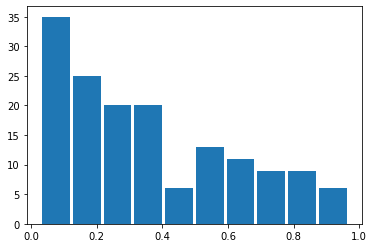

In [66]:
plt.hist(rslt_tbl['pred_val'], rwidth=0.9)
plt.hist

In [112]:
tmp_p = 0.1
tmp = (np.log(rslt_tbl['pred_val']+tmp_p)- np.log(tmp_p)) / (np.log(1+tmp_p)-np.log(tmp_p))

<function matplotlib.pyplot.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)>

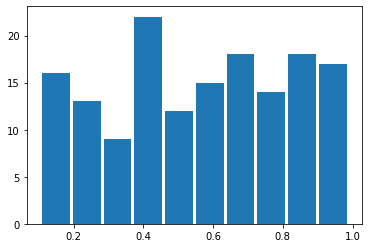

In [113]:
plt.hist(tmp, rwidth=0.9)
plt.hist

In [63]:
tmp2 = np.log2(rslt_tbl['pred_val'])

<function matplotlib.pyplot.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)>

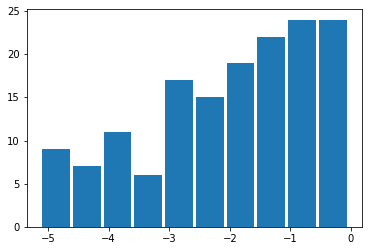

In [67]:
plt.hist(tmp2, rwidth=0.9)
plt.hist